### Polynomial Regression| Regularization| Assumptions

###### https://kaggle.com/code/farzadnekouei/polynomial-regression-regularization-assumptions

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

c:\Program Files\Python312\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Data Preprocessing

In [2]:
data = pd.read_csv('car data.csv')

In [3]:
df = pd.DataFrame(data)

In [4]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [5]:
df.shape

(301, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [7]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [8]:
df.describe(include='O')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


In [9]:
df["Car_Name"].nunique()

98

In [10]:
df.groupby("Car_Name")[["Car_Name"]].count()

,Car_Name
Car_Name,
800,1
Activa 3g,2
Activa 4g,1
Bajaj ct 100,1
Bajaj Avenger 150,1
...,...
sx4,6
verna,14
vitara brezza,1


- Since Car_Name contains 98 unique categories, and this number of categories is very high compared to the number of dataset samples, it is better to drop it:

In [11]:
df.drop('Car_Name', axis=1, inplace=True)

In [12]:
df.sample()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
96,2016,20.75,25.39,29000,Diesel,Dealer,Automatic,0


In [13]:
df["Age"] = (df["Year"].max() -  df["Year"])+1

In [14]:
df.drop('Year', axis=1, inplace=True)

In [15]:
df.sample()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
104,1.35,1.47,4100,Petrol,Individual,Manual,0,2


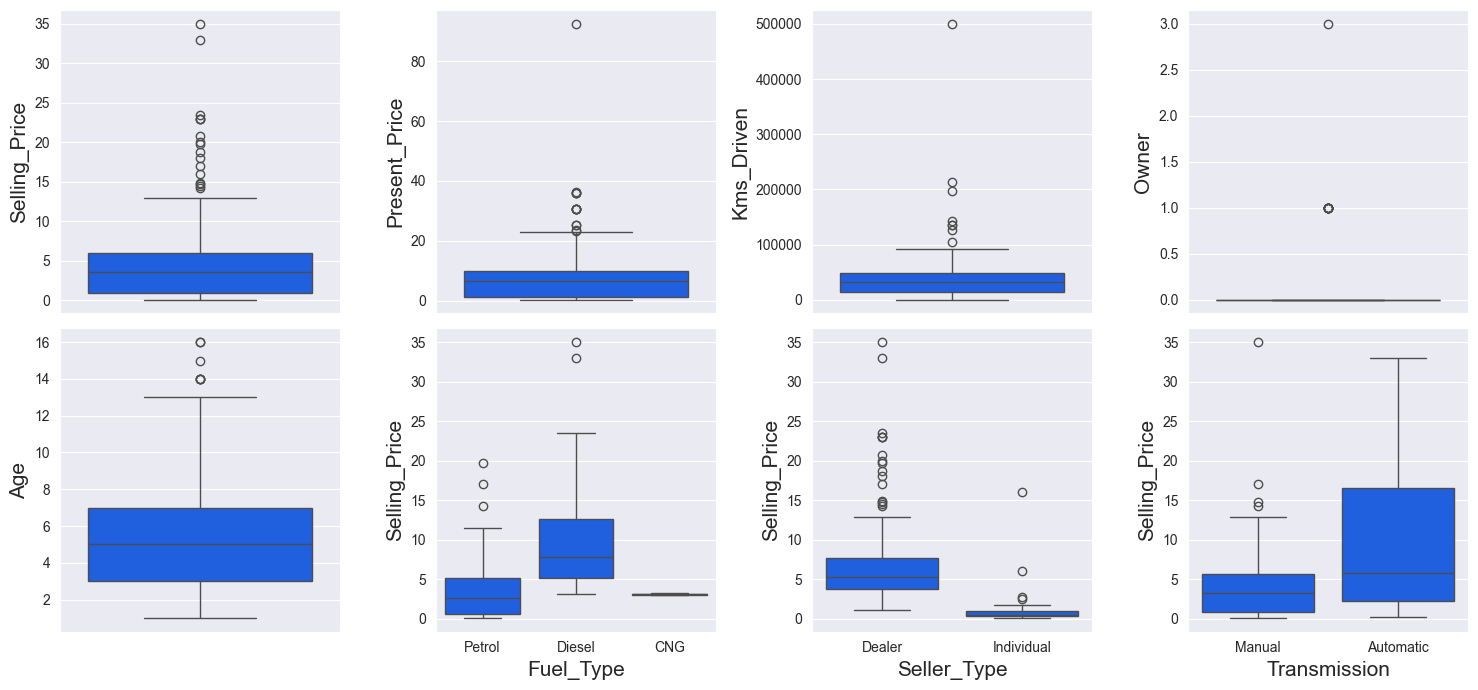

In [16]:
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values, 
                              df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

In [17]:
outliers_indexes = []
target = 'Selling_Price' 


for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
        
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


In [18]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

In [19]:
# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

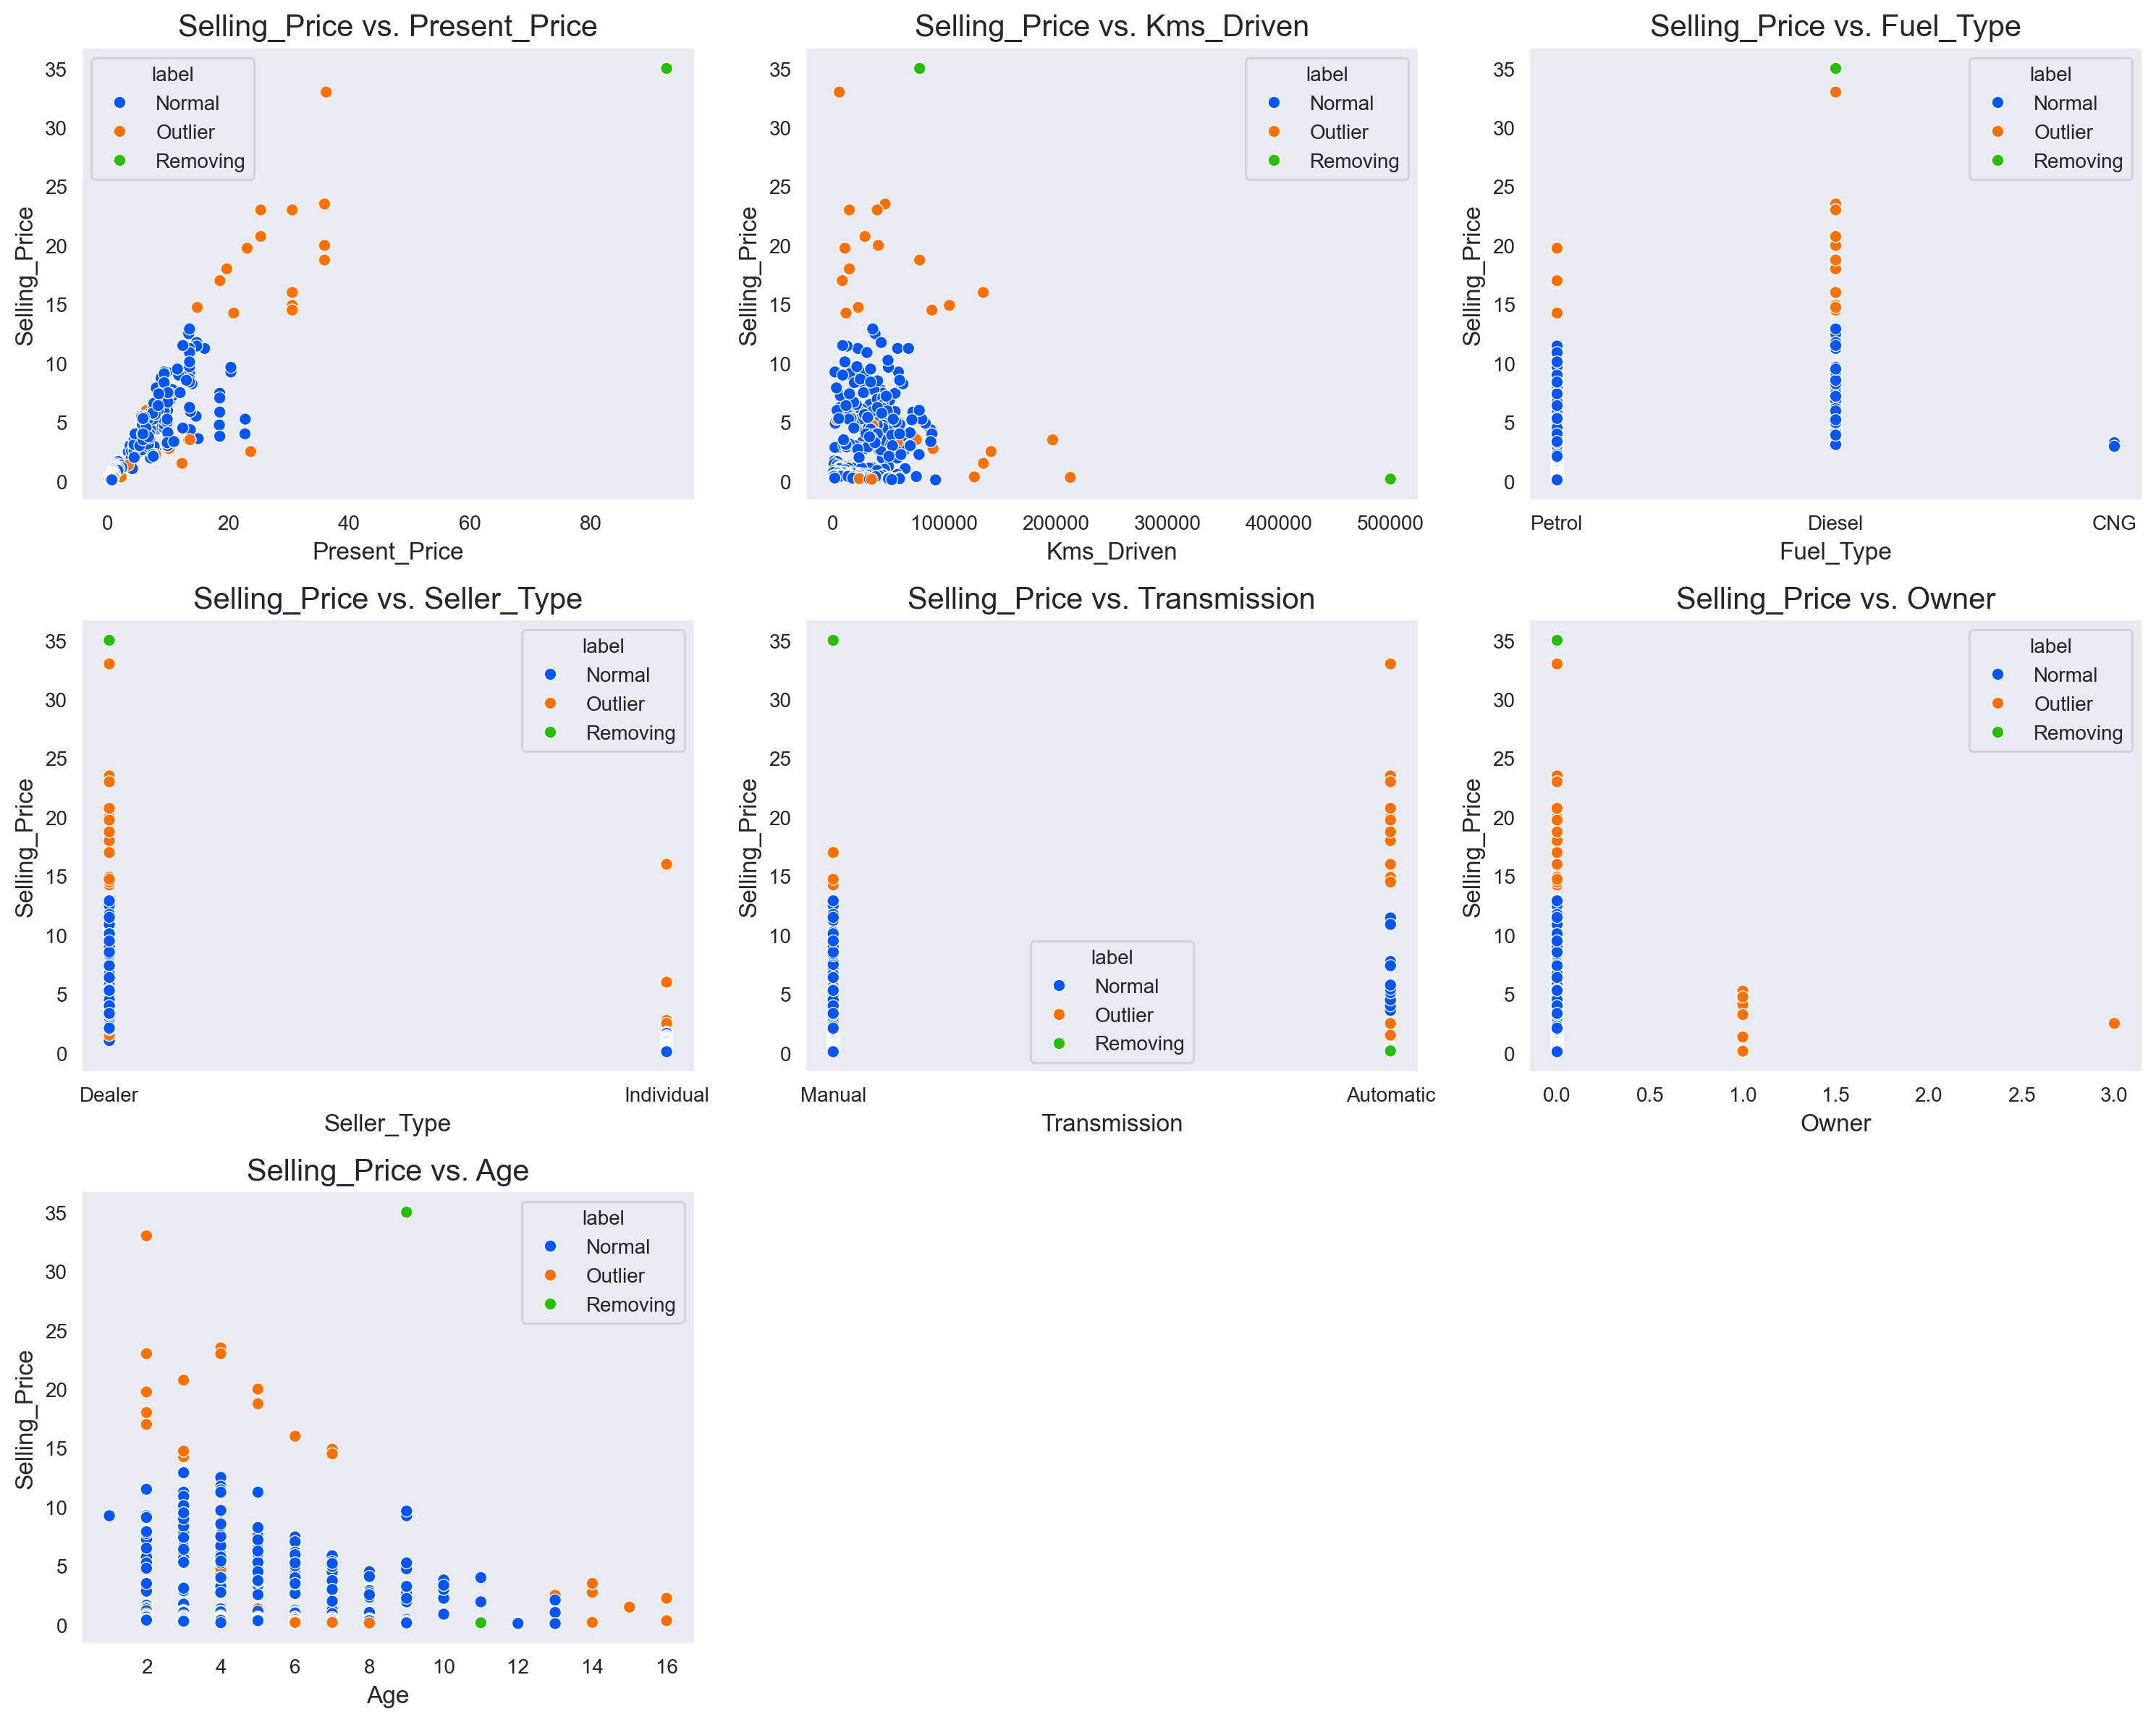

In [20]:
# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [21]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [22]:
df.isnull().sum()

Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
Age              0
dtype: int64

In [23]:
df.duplicated().sum()

2

In [24]:
df[df.duplicated()]

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
17,7.75,10.79,43000,Diesel,Dealer,Manual,0,3
93,23.00,30.61,40000,Diesel,Dealer,Automatic,0,4


In [25]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

### EDA 

In [26]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

In [27]:
Fuel_Type_value = df["Fuel_Type"].value_counts().values
Fuel_Type_index = df["Fuel_Type"].value_counts().index

Seller_Type_value = df["Seller_Type"].value_counts().values
Seller_Type_index = df["Seller_Type"].value_counts().index

Transmission_value = df["Transmission"].value_counts().values
Transmission_index = df["Transmission"].value_counts().index


fig = make_subplots(rows=1, cols=3, 
                    specs=[[{'type':'pie'}, {'type':'pie'}, {'type':'pie'}]], 
                    subplot_titles=("Fuel Type Distribution", "Seller Type Distribution", "Transmission Distribution"))

# Add Fuel_Type pie chart
fig.add_trace(go.Pie(values=Fuel_Type_value, labels=Fuel_Type_index, hole=0.5), 
              row=1, col=1)
# Add Seller_Type pie chart
fig.add_trace(go.Pie(values=Seller_Type_value, labels=Seller_Type_index, hole=0.5), 
              row=1, col=2)
# Add Transmission pie chart
fig.add_trace(go.Pie(values=Transmission_value, labels=Transmission_index, hole=0.5), 
              row=1, col=3)

# Show figure
fig.show()

In [28]:
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']

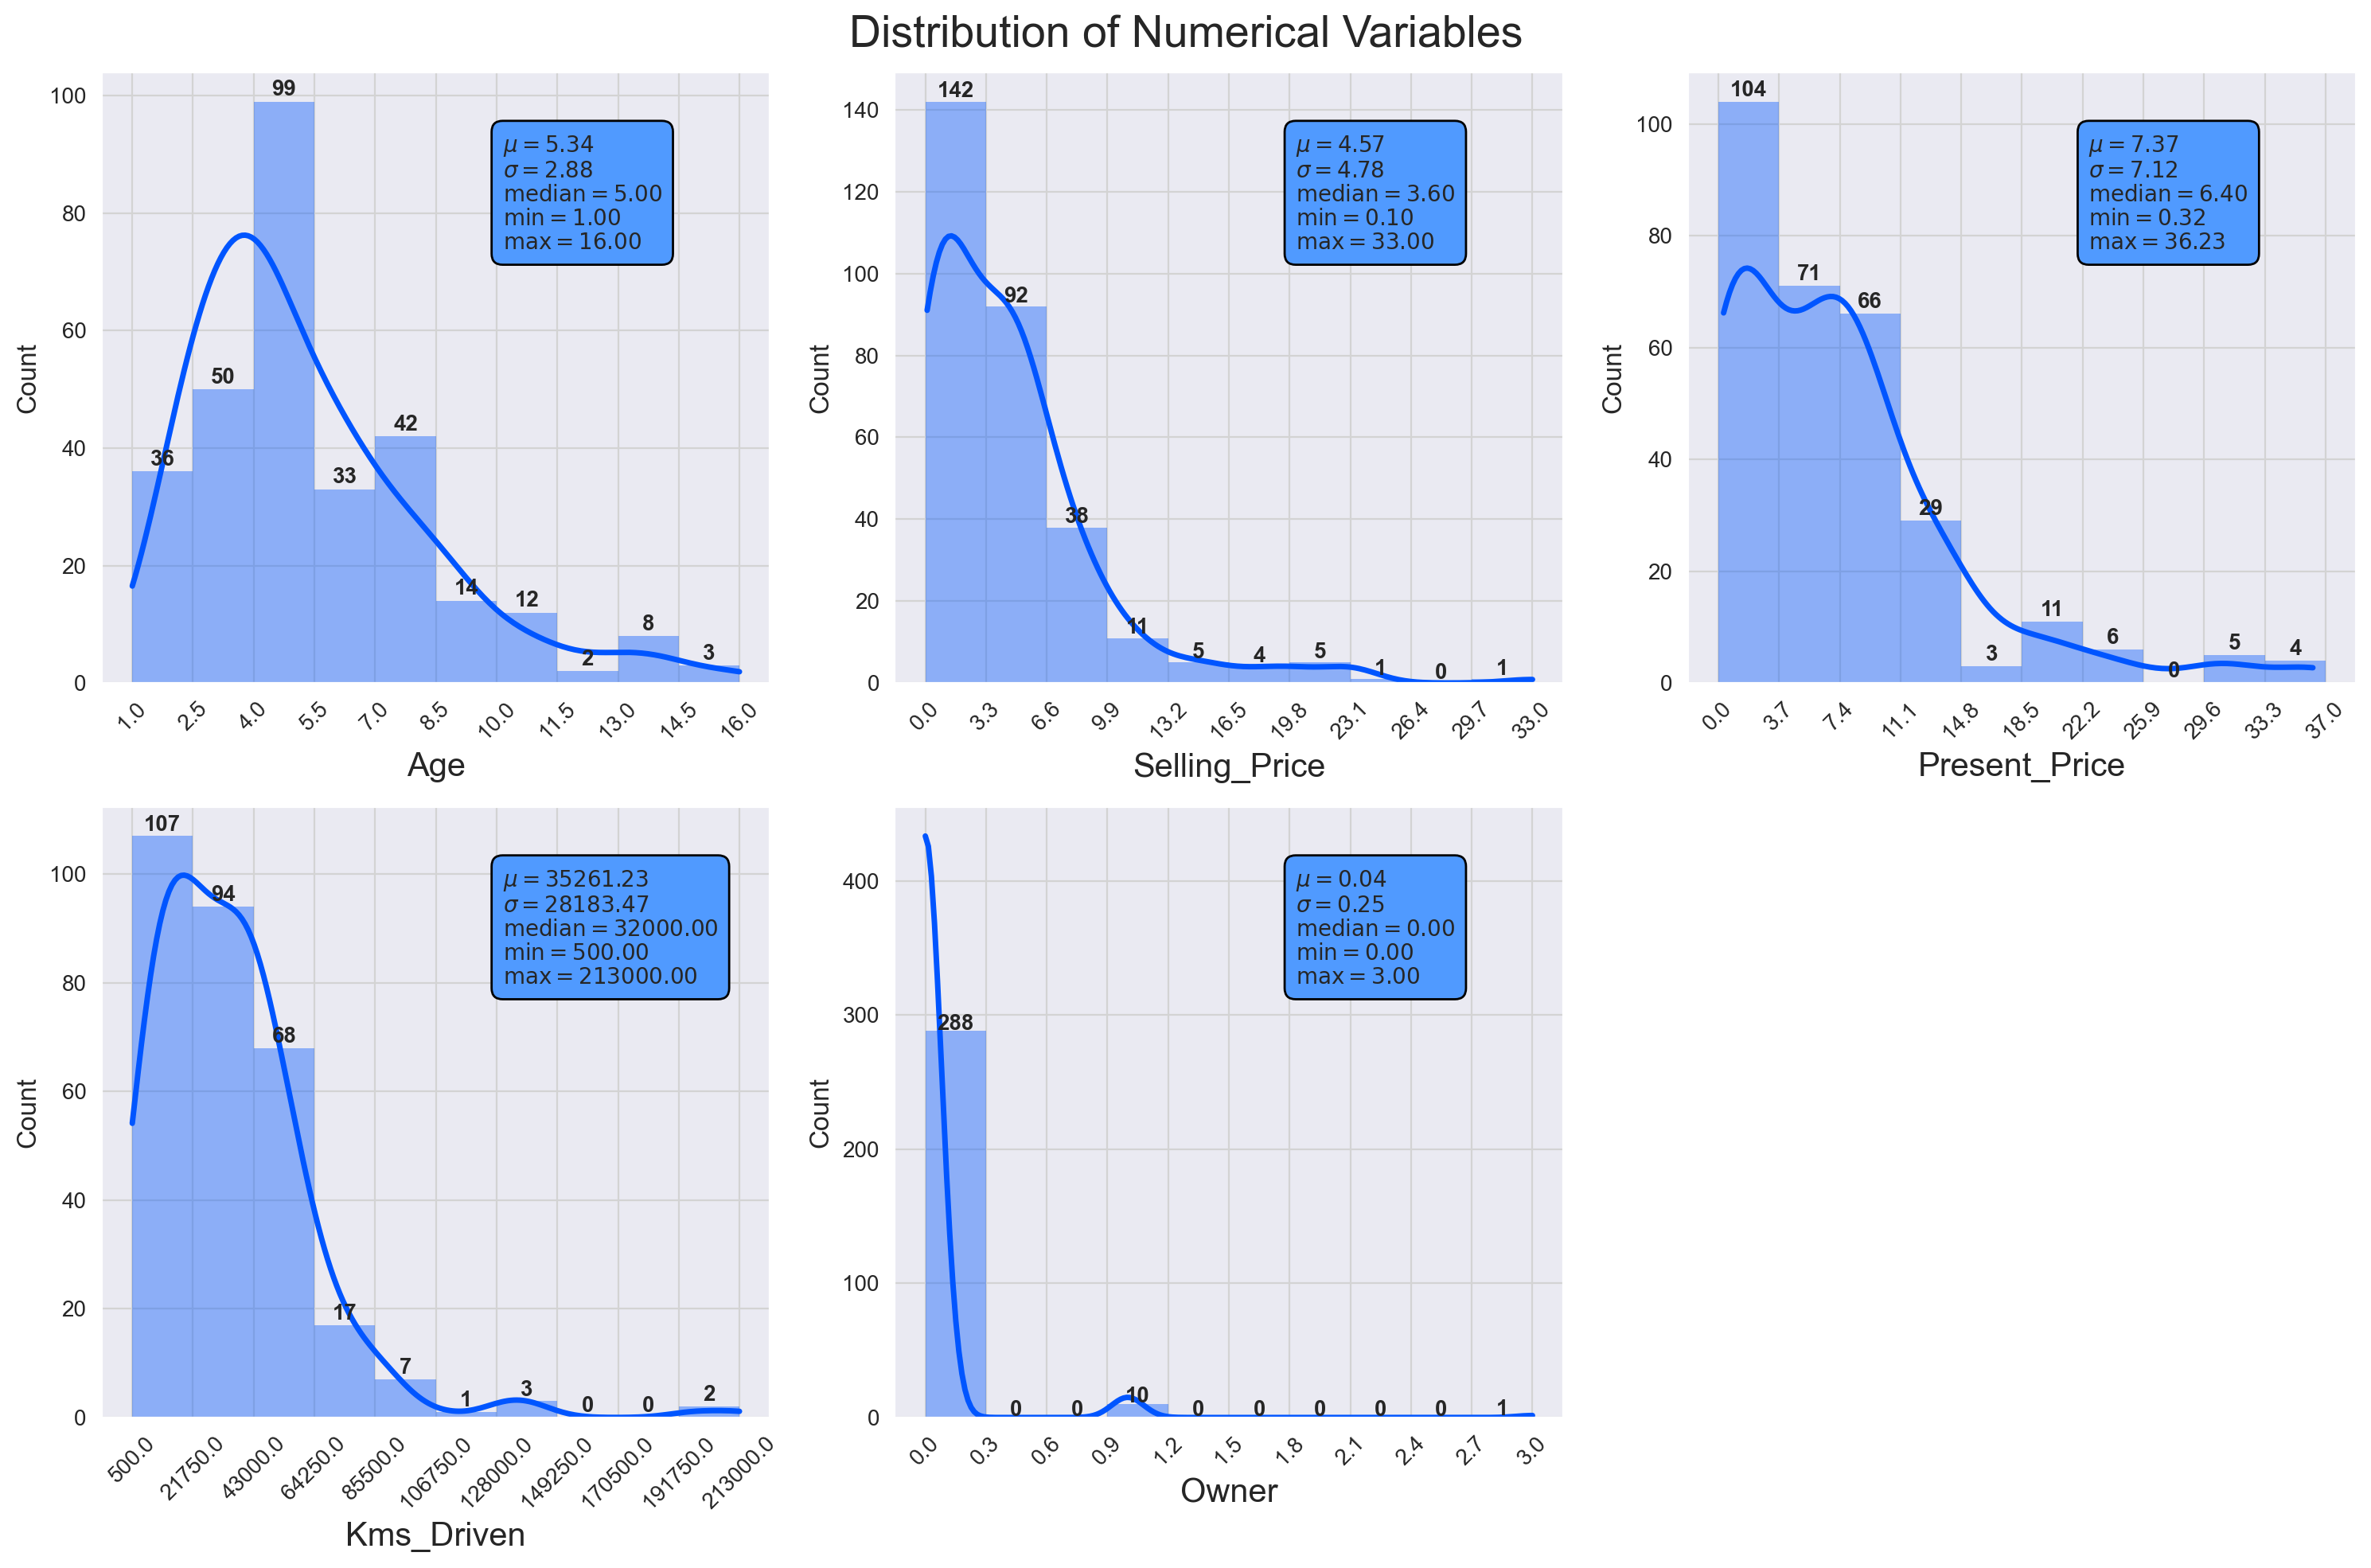

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]], 
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))                
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")

    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.show()

In [30]:
num_features = ['Present_Price', 'Kms_Driven', 'Age', 'Owner']
target = 'Selling_Price'

In [31]:
fig = make_subplots(rows=2, cols=2, subplot_titles=[f'{target} vs. {feature}' for feature in num_features])

# Add scatter plots with trendlines for each numerical feature
for i, feature in enumerate(num_features):
    row = i // 2 + 1  # Adding 1 to adjust for subplot indexing
    col = i % 2 + 1

    # Create a scatter plot with trendline
    scatter_fig = px.scatter(df1, x=feature, y=target, trendline="ols", 
                             title=f'{target} vs. {feature}',
                             color= "Fuel_Type",
                             size="Selling_Price",
                             labels={feature: feature, target: target})

    # Add the scatter plot to the subplot
    for trace in scatter_fig.data:
        fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(height=600, width=1000)

# Show figure
fig.show()

In [32]:
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
target = 'Selling_Price'

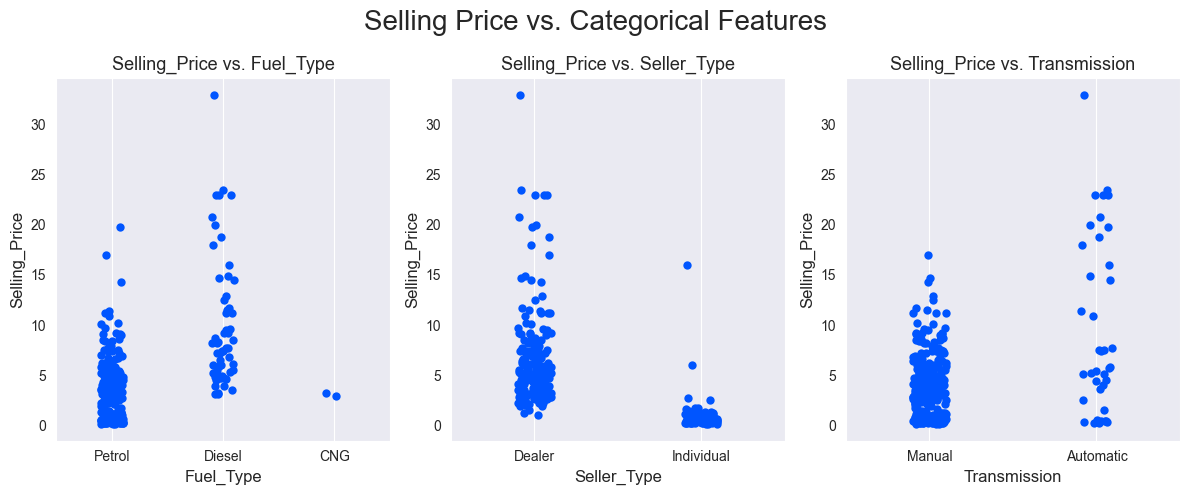

In [33]:
c = '#0055ff'
fig, axes = plt.subplots(nrows=1 ,ncols=3, figsize=(12,5), dpi=100)
for i in range(len(cat_features)):
    sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df1, size=6, color=c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[i].set_xlabel(cat_features[i], size = 12)
    axes[i].set_ylabel(target, size = 12)
    axes[i].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
plt.tight_layout()
plt.show()

### Data Encoding

In [37]:
encoder = LabelEncoder()

In [42]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

for i in CatCols:
    df1[i] = encoder.fit_transform(df1[i])

In [43]:
df1.sample(5)

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
168,0.40,0.54,14000,2,1,1,0,4
158,0.45,0.51,4000,2,1,0,0,2
55,3.60,15.04,70000,2,0,0,0,10
147,0.52,0.94,45000,2,1,1,0,9
113,1.15,1.47,17000,2,1,1,0,4


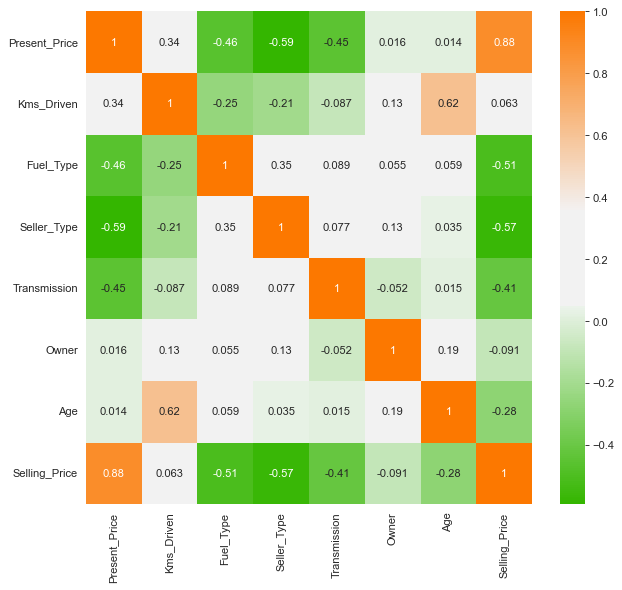

In [46]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

###  Determine Features & Target Variables

In [47]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (209, 7)
X_test shape:  (90, 7)
y_train shape:  (209,)
y_test shape:  (90,)


In [50]:
y_test_actual = y_test

### Scale Data

In [51]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
linear_reg = LinearRegression()

In [54]:
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [55]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), 
             index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,4.302488
Present_Price Coef.,3.600162
Transmission Coef.,0.047071
Owner Coef.,-0.242150
Seller_Type Coef.,-0.346382
Fuel_Type Coef.,-0.511616
Kms_Driven Coef.,-0.554755
Age Coef.,-0.975442


In [56]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

In [57]:
model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,1.195139
MSE,3.743209
RMSE,1.934738
R2-Score,0.886386


In [58]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.166560,0.152167
MSE,3.224666,1.349637
RMSE,1.753716,0.386193
R2-Score,0.851643,0.036791
